In [297]:
import pandas as pd
import numpy as np
from kernel_utils import *

import matplotlib.pyplot as plt
from matplotlib import cm
from numpy import linalg as LA
from tqdm import tqdm

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [2]:
X = pd.read_csv('data/Xtr1_mat50.csv', sep=' ', header=None)
Y = pd.read_csv('data/Ytr1.csv', sep=',', header=0)
X_t = pd.read_csv('data/Xte1_mat50.csv', sep=' ', header=None)
# Y_test = pd.read_csv('data/Yte0.csv', sep=',', header=0)
Y.columns = ["idx", "bound"]
Y = Y.drop(["idx"], axis=1)
# Y_test.columns = ["idx", "bound"]
# Y_test = Y_test.drop(["idx"], axis=1)

X_raw = pd.read_csv('data/Xtr1.csv', sep=' ', header=None)





In [3]:
# Construction of the proteine

from itertools import product
from string import ascii_lowercase
base_azote = ['A', 'C', 'T', 'G']

# Creation of all possible combinations
dic_prot = [''.join(i) for i in product(base_azote, repeat = 3)]
nb_feat = len(dic_prot)
print(dic_prot)

['AAA', 'AAC', 'AAT', 'AAG', 'ACA', 'ACC', 'ACT', 'ACG', 'ATA', 'ATC', 'ATT', 'ATG', 'AGA', 'AGC', 'AGT', 'AGG', 'CAA', 'CAC', 'CAT', 'CAG', 'CCA', 'CCC', 'CCT', 'CCG', 'CTA', 'CTC', 'CTT', 'CTG', 'CGA', 'CGC', 'CGT', 'CGG', 'TAA', 'TAC', 'TAT', 'TAG', 'TCA', 'TCC', 'TCT', 'TCG', 'TTA', 'TTC', 'TTT', 'TTG', 'TGA', 'TGC', 'TGT', 'TGG', 'GAA', 'GAC', 'GAT', 'GAG', 'GCA', 'GCC', 'GCT', 'GCG', 'GTA', 'GTC', 'GTT', 'GTG', 'GGA', 'GGC', 'GGT', 'GGG']


In [4]:
from tqdm import tqdm

k=3
def k_spectre(seq, k=3):
    """
    Combine all the k-successive
    """
    k_seq = []
    for i in range(len(seq)-k+1):
        tmp = ''
        for j in range(k):
            tmp += seq[i+j]
        k_seq.append(tmp)
    return k_seq

init_feat = pd.DataFrame(0, index=[0], columns=dic_prot)
# init_feat.append(np.zeros(4**k))

def count_kuplet(k_seq):
    k = len(k_seq[0])
    new_feat = init_feat.copy()
    for kuplet in k_seq:
        new_feat[kuplet] += 1.
    return np.array(new_feat).reshape(4**k)

def feature_exractor(X, k=3):
    X_processed = []
    for seq in tqdm(X[0]):
        X_processed.append(count_kuplet(k_spectre(seq)))
    
    return np.array(X_processed)

    
test = feature_exractor(X_raw)    
print(test)

100%|██████████| 2000/2000 [01:32<00:00, 21.61it/s]

[[ 1.  1.  1. ...,  4.  0.  1.]
 [ 3.  1.  0. ...,  3.  2.  3.]
 [ 0.  0.  0. ...,  0.  2.  0.]
 ..., 
 [ 0.  0.  1. ...,  3.  1.  3.]
 [ 0.  1.  0. ...,  2.  1.  1.]
 [ 4.  1.  0. ...,  4.  0.  3.]]


In [109]:
test.shape

(2000, 64)

In [168]:
test2 = test[:100]
print(test2.shape)

(100, 64)


In [360]:
def preprocessing(X, Y, percent=0.8):
    """
    Preprocessing the data.
        - Shuffle
        - Divide data and labels
        - centering
        - add dimension to the data
        - cut into a training dataset and a test dataset
    """

    # Shuffle phase
    np.random.RandomState(1)
    tmp = np.concatenate((X, np.matrix(Y)), axis=1)
    np.random.shuffle(tmp)
    X_tmp = tmp[:, :X.shape[1]]

    # changing the value to {-1,1}
    Y_tmp = (Y - 0.5) * 2

    # centering data
    # X = X-np.mean(X, axis=0)

    # Scaling data
    # X = scale( X, axis=0, with_mean=True, with_std=True, copy=True )

    # Add one dimension to your data points in order to account for
    # the offset if your data is not centered.
    X_tmp = np.concatenate((X_tmp, np.ones((X_tmp.shape[0], 1))), axis=1)

    # Compute the training and the test set
    n_training = int(percent  * Y.size)
    X_train = X_tmp[:n_training]
    Y_train = Y_tmp[:n_training]
    X_test = X_tmp[n_training:]
    Y_test = Y_tmp[n_training:]

    return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = preprocessing(X[:400], np.transpose(np.matrix(Y['bound'][:400])), percent=0.24)

In [361]:
# test = np.asarray(test)
K = np.dot(X_train, X_train.T)
n = K.shape[0]
print(n)

96


In [362]:
def transform_svm_primal(K,y,lamb):
    """
    Transform the primal Support Vector Machine (SVM)
    problem into a quadratic problem
    Args:
        - K : Kernel of x
        - Y : Target labels
        - lamb : regularization parameter
    Ouput:
        - Q : semi-definite matrix (quadratic parameter)
        |K   0 |
        |0     0 |

        - P : vector parameter in the minimization part
        |0,...,0 , 1, ..., 1|^t / lamb

        - A : matrix constraint
        |-yK   -I |
        |0     -I |

        - b : vector constraint
        |-1,...,-1 , 0, ..., 0|^t

    """
    K = np.matrix(K, dtype=np.float)
    y = np.array(y, dtype=np.float)

    # number of data
    n = y.size

    # Verify the shape of the data
    try:
        assert K.shape[0] == n
    except AssertionError:
        print("K and Y must have the same length")
        exit(1)

    A1 = np.concatenate((-np.transpose(np.multiply(K, y)), -np.eye(n)), axis=1)
    A2 = np.concatenate((np.zeros((n,n)), -np.eye(n)), axis=1)
    A = np.concatenate((A1, A2), axis=0)

    Q1 = np.concatenate((K, np.zeros((n,n))), axis=1)
    Q2 = np.zeros((n, 2*n))
    Q = lamb * np.concatenate((Q1, Q2), axis=0)

    p = np.concatenate((np.zeros(n), np.ones(n)), axis=0) / n

    b = np.concatenate((-np.ones(n), np.zeros(n)), axis=0)


    return Q, p, A, b



In [369]:
from cvxopt import matrix, solvers

Q, p, A, b = transform_svm_primal(K,Y_train, 0.01)

Q = matrix(2*Q)
p = matrix(p)
G = matrix(A)
h = matrix(b)
A = matrix(np.matrix(np.repeat(0.0, 2*n)))
b = matrix(0.0)
sol=solvers.qp(Q, p, G, h) # A, b)
# print(sol['x'])

     pcost       dcost       gap    pres   dres
 0: -1.0417e-02  1.0000e+00  2e+02  1e+00  1e+03
 1:  9.6963e-01 -1.8915e+00  3e+00  1e-02  1e+01
 2:  2.4580e-01 -1.2181e-02  3e-01  1e-04  1e-01
 3:  2.4820e-03 -9.8424e-05  3e-03  1e-06  1e-03
 4:  2.4820e-05 -9.8187e-07  3e-05  1e-08  1e-05
 5:  2.4830e-07 -9.8226e-09  3e-07  1e-10  1e-07
Terminated (singular KKT matrix).


In [370]:
w = np.array(sol['x'])
print(np.array(w).shape)

(192, 1)


In [365]:
np.repeat(0.0, 2*n).shape

(192,)

In [366]:
w,v = np.linalg.eigh(K)
print(w)

[ -7.80867961e-15  -5.06435694e-15  -4.61161834e-15  -4.00950488e-15
  -4.00908780e-15  -3.56429366e-15  -3.17175331e-15  -2.81535955e-15
  -2.59962579e-15  -2.45059245e-15  -2.30021896e-15  -1.96121353e-15
  -1.91445610e-15  -1.87038667e-15  -1.62057330e-15  -1.39231394e-15
  -1.29131963e-15  -8.45333840e-16  -5.90172117e-16  -4.67250006e-16
  -4.64945835e-16  -2.31635458e-16  -1.62515987e-16   6.37365589e-17
   2.48749398e-16   3.34694063e-16   5.60130276e-16   7.20875239e-16
   1.05695231e-15   1.10040163e-15   1.34944247e-15   1.72667435e-15
   1.74214579e-15   1.74297644e-15   1.82101168e-15   2.29722004e-15
   2.44123065e-15   2.82691886e-15   2.89013654e-15   3.23727390e-15
   3.35301799e-15   3.92264614e-15   4.05607812e-15   4.41414867e-15
   4.82480895e-15   1.01384912e-14   6.61745726e-04   8.32160657e-04
   1.07979121e-03   1.33671548e-03   1.44606188e-03   1.59887301e-03
   2.17873917e-03   2.82677738e-03   2.98327087e-03   3.14869977e-03
   3.69411858e-03   4.11633440e-03

In [367]:
w,v = np.linalg.eigh(np.dot(A.T, A))
print(w)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [368]:
print(A.shape)

AttributeError: 'cvxopt.base.matrix' object has no attribute 'shape'

In [273]:
print(np.dot(A, w_0) - b)

ValueError: shapes (160,160) and (80,) not aligned: 160 (dim 1) != 80 (dim 0)

In [274]:
def phi(x,t,Q,p,A,b):
    """
    Compute the fonction value
    """
    x = np.array(x, dtype=np.float)
    Q = np.matrix(Q, dtype=np.float)
    p = np.array(p, dtype=np.float)
    A = np.matrix(A, dtype=np.float)
    b = np.array(b, dtype=np.float)

    phit = (0.5*x.dot(Q).dot(x) + p.dot(x))

    phit = t*phit

    tmp = b - A.dot(x)
    tst = tmp < 0
    # print("negatif dans le log")
    print(np.sum(tst)<1)
    tmp = np.log(tmp)

    phit = np.array(phit - np.sum(tmp))[0][0]
    return phit

def grad(x,t,Q,p,A,b):
    """
    Compute the gradient of phit
    """
    x = np.array(x, dtype=np.float)
    Q = np.matrix(Q, dtype=np.float)
    p = np.array(p, dtype=np.float)
    A = np.matrix(A, dtype=np.float)
    b = np.array(b, dtype=np.float)

    gradt = Q.dot(x) + p
    gradt = t * gradt

    tmp = b - A.dot(x)
    tmp = 1./tmp
    gradt = np.array(gradt + tmp.dot(A))[0]
    return gradt


def hess(x,t,Q,p,A,b):
    """
    Compute the Hessian of phit
    """
    x = np.array(x, dtype=np.float)
    Q = np.matrix(Q, dtype=np.float)
    p = np.array(p, dtype=np.float)
    A = np.matrix(A, dtype=np.float)
    b = np.array(b, dtype=np.float)

    hesst = t*Q
    tmp = b - A.dot(x)
    tmp = 1./np.square(tmp)
    tmp = np.diag(np.array(tmp)[0])
    tmp = (A.T).dot(tmp).dot(A)
    # print("est ce que le terme de barriere est positif?")
    print(np.all(np.linalg.eigvals(np.dot(A.T, A)) >= -0.001))
    hesst = hesst + tmp

    return hesst


def dampedNewtonStep(x,f,g,h):
    """
    Compute the damped Newton step at point x
    Args:
        - x : point where the Newton step will be computed
        - f : the value function
        - g : the gradient function
        - h : the hessian function
    Ouput:
        - x_new : the damped Newton step at point x
        - lamdat2/2 : the estimated gap before the minimum
    """
    phit = f(x)
    gradt = np.array(g(x), dtype=np.float)
    hesst = np.matrix(h(x), dtype=np.float)
    # print(hesst.shape)
    hesst_inv = np.linalg.inv(hesst)
    # print(hesst_inv)
    
    # print("est ce que l'inverse est positif ? ")
    print(np.all(np.linalg.eigvals(hesst_inv) >= -0.001))


    lambdat2 = np.array(gradt.dot(hesst_inv).dot(gradt))
    # print(lambdat2)
    # if lambdat2 < 0:
        # print(lambdat2)
     #    print('probleme pour lambda (devrait etre positif)')
    # else :
    #     print('ok pour lambda')
    coef = (1.+np.sqrt(lambdat2))
    coef = 1./coef
    x_new = np.array(x - coef * hesst_inv.dot(gradt))[0]
    # print("ESPION3")

    return x_new, lambdat2/2



def dampedNewton(x0,f,g,h,tol,Tmax=20):
    """
    Implement the damped Newton algorithm
    Args:
        - x0 : initial point
        - f : the value function to minimize
        - g : the gradient function
        - h : the hessian function
        - tol : the threshold (smaller than 0.3819660112501051)
        - Tmax : maximum number of iteration
    Ouput:
        - xstar : the point tol-minimizing f
        - xhist : the history of damped step
    """
    try:
        assert tol < 0.3819660112501051
    except AssertionError:
        print("The threshold in dampedNewton must be smaller ")
        exit(1)
    xstar, gap = dampedNewtonStep(x0,f,g,h)
    xhist = [x0, xstar]
    phi_w_hist = [f(x0), f(xstar)]
    it = 1
    while(gap>tol and it<Tmax):
        it +=1
        xstar, gap = dampedNewtonStep(xstar,f,g,h)
        # print("ESPION2")
        phi_w_hist.append(f(xstar))
        xhist.append(xstar)
    xhist = np.array(xhist)

    return xstar, xhist, phi_w_hist



def barr_method(Q,p,A,b,x_0,mu,tol):
    """
    Solve the Quadratic problem using damped Newton method
    Args:
        - Q : semi-definite matrix (quadratic parameter)
        - P : vector parameter in the minimization part
        - A : matrix constraint
        - b : vector constraint
        - x_0 : inital state
        - mu :  increment of the barrier parameter
        - tol : the threshold
    Ouput:
        - x_sol : the argument minimizing the quadratic problem
        - x_hist : the history of step
    """
    t = mu
    x_sol = x_0
    x_hist = np.matrix(x_sol)
    phi_w_hist = []
    it=0
    while(mu/t > tol):
        it+=1
        # if(it%100 == 0):
        print("we want {} to be less than {}".format(mu/t, tol))
        f = lambda x: phi(x,t,Q,p,A,b) ;
        g = lambda x: grad(x,t,Q,p,A,b) ;
        h = lambda x: hess(x,t,Q,p,A,b) ;
        x_sol, xhist_tmp, ph_w_tmp = dampedNewton(x_sol,f,g,h,tol)
        # print("ESPION1")
        x_hist = np.concatenate((x_hist, xhist_tmp), axis = 0)
        phi_w_hist.append(ph_w_tmp)
        t = mu*t

    #phi_w_hist.append(f(x_sol))
    return x_sol, x_hist, phi_w_hist



In [275]:
w_0 = np.append(np.repeat(0., K.shape[0]), np.repeat(2., K.shape[0]))
# w, w_hist, phi_w_hist = barr_method(Q,p,A,b,w_0,1.2,0.1)
# w_0 = w


In [284]:
w, w_hist, phi_w_hist = barr_method(Q,p,A,b,w_0,mu = 10.,tol = 0.001)


we want 1.0 to be less than 0.001
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
we want 0.1 to be less than 0.001
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
we want 0.01 to be less than 0.001
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
Tr

In [371]:
# f_predict = lambda x: 
tmp = np.dot(X_test, np.transpose(X_train))
result = np.dot(tmp, w[:n])

In [372]:
Y_predicted = result > 0.

In [373]:
Y_predicted

matrix([[False],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [False],
        [ True

In [374]:
tmp2 = (Y_test == (Y_predicted - 0.5)*2)

In [375]:
np.mean(tmp2)

0.5

In [324]:
np.transpose((Y_predicted - 0.5)*2)

matrix([[-1.,  1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1.,
          1., -1., -1.,  1., -1., -1., -1.]])

In [326]:
print("accuracy for testing : {}".format(np.sum(Y_test == np.transpose(Y_predicted))/len(Y_test)))

accuracy for testing : 2.1


In [104]:
from sklearn import svm

clf = svm.SVC(C=.001, kernel='poly', degree=3)

clf.fit(X_train, Y_train['bound'])
Y_pred = clf.predict(X_test)
Y_train_pred = clf.predict(X_train)
print("accuracy for testing : {}".format(np.sum(Y_test['bound'] == Y_pred)/len(Y_test)))
print("accuracy for training : {}".format(np.sum(Y_train_pred == Y_train['bound'])/len(Y_train)))
# print(Y_train_pred.shape)

accuracy for testing : 0.4975
accuracy for training : 0.575


In [78]:
from sklearn.kernel_ridge import KernelRidge

clf = KernelRidge(alpha=.1)
clf.fit(X_train, Y_train['bound'])
Y_pred = clf.predict(X_test) > 0.5
Y_train_pred = clf.predict(X_train) > 0.5
print("accuracy for testing : {}".format(np.sum(Y_test['bound'] == Y_pred)/len(Y_test)))
print("accuracy for training : {}".format(np.sum(Y_train_pred == Y_train['bound'])/len(Y_train)))


accuracy for testing : 0.5325
accuracy for training : 0.584375


In [79]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=5, max_depth=None, min_samples_split=4, random_state=0)
clf.fit(X_train, Y_train['bound'])
Y_pred = clf.predict(X_test)
Y_train_pred = clf.predict(X_train)
print("accuracy for testing : {}".format(np.sum(Y_test['bound'] == Y_pred)/len(Y_test)))
print("accuracy for training : {}".format(np.sum(Y_train_pred == Y_train['bound'])/len(Y_train)))


accuracy for testing : 0.495
accuracy for training : 0.9175


In [80]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=5, learning_rate=.1, max_depth=5, random_state=0)
clf.fit(X_train, Y_train['bound'])
Y_pred = clf.predict(X_test)
Y_train_pred = clf.predict(X_train)
print("accuracy for testing : {}".format(np.sum(Y_test['bound'] == Y_pred)/len(Y_test)))
print("accuracy for training : {}".format(np.sum(Y_train_pred == Y_train['bound'])/len(Y_train)))

accuracy for testing : 0.4775
accuracy for training : 0.731875


In [87]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(100, input_dim=50, activation='sigmoid', kernel_initializer='random_uniform'))
model.add(Dense(50, activation='sigmoid', kernel_initializer='random_uniform'))
# model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# am = Adam(lr=0.01)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train['bound'], epochs=20, batch_size=5)

# clf.fit(X_train, )
Y_pred = model.predict(X_test)>0.5
Y_train_pred = model.predict(X_train)>0.5
print("accuracy for testing : {}".format(np.sum(Y_test == Y_pred)/len(Y_test)))
print("accuracy for training : {}".format(np.sum(Y_train_pred == Y_train)/len(Y_train)))

Epoch 1/20
1600/1600 [==============================] - 1s 691us/step - loss: 0.7011 - acc: 0.4806
Epoch 2/20
1600/1600 [==============================] - 1s 359us/step - loss: 0.6986 - acc: 0.4881
Epoch 3/20
1600/1600 [==============================] - 1s 376us/step - loss: 0.6984 - acc: 0.5119
Epoch 4/20
1600/1600 [==============================] - 1s 376us/step - loss: 0.6970 - acc: 0.4963
Epoch 5/20
1600/1600 [==============================] - 1s 391us/step - loss: 0.6964 - acc: 0.5144 0s - loss: 0.6940 -
Epoch 6/20
1600/1600 [==============================] - 1s 370us/step - loss: 0.6972 - acc: 0.4838
Epoch 7/20
1600/1600 [==============================] - 1s 376us/step - loss: 0.6965 - acc: 0.4988
Epoch 8/20
1600/1600 [==============================] - 1s 413us/step - loss: 0.6959 - acc: 0.5113 0s - loss: 0.6950 - 
Epoch 9/20
1600/1600 [==============================] - 1s 381us/step - loss: 0.6959 - acc: 0.5019
Epoch 10/20
1600/1600 [==============================] - 1s 450us/st

In [12]:
Y_pred.shape

(400, 1)

Bon en fait j'ai l'impression que a marche pas de ouf cette représentation des ACTG... Faut qu'on trouve notre propre truc.


In [92]:
# Construction of the proteine

from itertools import product
from string import ascii_lowercase
base_azote = ['A', 'C', 'T', 'G']

# Creation of all possible combinations
dic_prot = [''.join(i) for i in product(base_azote, repeat = 3)]
nb_feat = len(dic_prot)
print(dic_prot)

['AAA', 'AAC', 'AAT', 'AAG', 'ACA', 'ACC', 'ACT', 'ACG', 'ATA', 'ATC', 'ATT', 'ATG', 'AGA', 'AGC', 'AGT', 'AGG', 'CAA', 'CAC', 'CAT', 'CAG', 'CCA', 'CCC', 'CCT', 'CCG', 'CTA', 'CTC', 'CTT', 'CTG', 'CGA', 'CGC', 'CGT', 'CGG', 'TAA', 'TAC', 'TAT', 'TAG', 'TCA', 'TCC', 'TCT', 'TCG', 'TTA', 'TTC', 'TTT', 'TTG', 'TGA', 'TGC', 'TGT', 'TGG', 'GAA', 'GAC', 'GAT', 'GAG', 'GCA', 'GCC', 'GCT', 'GCG', 'GTA', 'GTC', 'GTT', 'GTG', 'GGA', 'GGC', 'GGT', 'GGG']


In [5]:
X_raw = pd.read_csv('data/Xtr1.csv', sep=' ', header=None)
# test on one sequence
seq = X_raw[0][:5]
# print(len(seq))
print(seq)
# print(Y['bound'][:10])

0    CGGGCCTCCTCCAGGCTCAGAATCGACCCCCCCCCATCCTGATAGA...
1    CTCCGCCCGCACTTCCGTCTGGACGCGAAGGCGTCACCGGGCGCGC...
2    GGTGTCTAGTCACATTACCTGAGATCTGACATTTTTATCCGTCTGA...
3    CGGCCTCCCTACCCCAGCCTCGCTCTGGGCGCCGTGACGTCACCTC...
4    GTTTGAATGGTGATCACGTGACGGGGCGGTGACGTCACCCGCCCTG...
Name: 0, dtype: object


In [106]:
from tqdm import tqdm

k=3

def k_spectre(seq, k=3):
    """
    Combine all the k-successive
    """
    k_seq = []
    for i in range(len(seq)-k+1):
        tmp = ''
        for j in range(k):
            tmp += seq[i+j]
        k_seq.append(tmp)
    return k_seq

init_feat = pd.DataFrame(0, index=[0], columns=dic_prot)
# init_feat.append(np.zeros(4**k))

def count_kuplet(k_seq):
    k = len(k_seq[0])
    new_feat = init_feat.copy()
    for kuplet in k_seq:
        new_feat[kuplet] += 1.
    return np.array(new_feat).reshape(4**k)

def feature_exractor(X, k=3):
    X_processed = []
    for seq in tqdm(X[0]):
        X_processed.append(count_kuplet(k_spectre(seq)))
    
    return X_processed

    
test = feature_exractor(X_raw)    
test = np.array(test)


  3%|▎         | 59/2000 [00:02<01:29, 21.61it/s]


KeyboardInterrupt: 

In [121]:
test = np.asarray(test)
K = np.dot(test, test.T)
K.shape

(2000, 2000)

In [130]:
N, d = test.shape
lamb = 0.5

test2 = np.matrix(test)

A1 = np.concatenate((-K, -np.eye(N)), axis=1)
A2 = np.concatenate((np.zeros((N,N)), -np.eye(N)), axis=1)
A = np.concatenate((A1, A2), axis=0)

Q1 = np.concatenate((K, np.zeros((N,N))), axis=1)
Q2 = np.zeros((N, 2*N))
Q = np.concatenate((Q1, Q2), axis=0)

p = np.concatenate((np.zeros(N), np.ones(N)), axis=0) / lamb

b = np.concatenate((-np.ones(N), np.zeros(N)), axis=0) 


In [145]:
# np.multiply(K,)
Y_tmp = np.array(Y['bound'])
Y_tmp = (Y_tmp - 0.5) * 2
tmp_test = np.multiply(Y_tmp,K)

In [146]:
tmp_test

array([[-321.,  199.,  -95., ...,  157., -176., -179.],
       [-199.,  323., -106., ...,  205., -167., -159.],
       [ -95.,  106., -299., ...,  132., -153., -132.],
       ..., 
       [-157.,  205., -132., ...,  249., -141., -152.],
       [-176.,  167., -153., ...,  141., -283., -128.],
       [-179.,  159., -132., ...,  152., -128., -297.]])

In [140]:
Y_tmp

array([0, 1, 0, ..., 1, 0, 0])

In [125]:
print(Q.shape)

(4000, 4000)


In [119]:
print(N)

2000


In [105]:
w_value_hist = []
ac_range = []
ac_range2 = []
# for tau = 0.0001 et tol = 0.1 on obtient acc = 59.5
# for tau = [0.005, 0.01, 0.05] on obtient : [53.5, 49.5, 46.5]

taurange = [0.0001] # , 0.1, 0.15, 0.2, 0.3]

for tau in taurange:
    acc_range=[]
    it = 0
    # while(it < 20):
    # for it in tqdm(range(0)):
    X_train, Y_train, X_test, Y_test = preprocessing(X, Y)
    mu = 1.1
    w, w_hist, phi_w_hist = SVM_vector(X_train, Y_train['bound'], tau, mu, tol=0.3)
    print('etape3')
    w_value_hist.append(w)
    Y_train_predicted, acc_train = predict(w, X_train, Y_train['bound'])
    Y_predicted, acc = predict(w, X_test, Y_test['bound'])
    
    ac_range.append(acc_train)
    ac_range2.append(acc)

we want 1.0 to be less than 0.3
we want 0.9090909090909091 to be less than 0.3
we want 0.8264462809917353 to be less than 0.3
we want 0.7513148009015775 to be less than 0.3
we want 0.6830134553650704 to be less than 0.3
we want 0.6209213230591548 to be less than 0.3
we want 0.5644739300537771 to be less than 0.3
we want 0.5131581182307065 to be less than 0.3
we want 0.4665073802097331 to be less than 0.3
we want 0.42409761837248455 to be less than 0.3
we want 0.38554328942953137 to be less than 0.3
we want 0.35049389948139215 to be less than 0.3
we want 0.31863081771035645 to be less than 0.3
etape3


In [176]:
print(ac_range)

[50.0]


In [177]:
print(ac_range2)

[50.0]


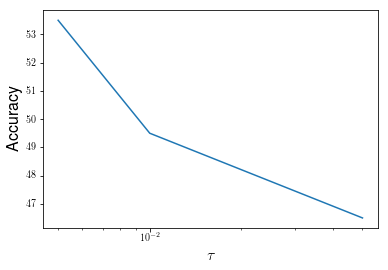

In [12]:
fig = plt.figure()
ax = fig.gca()
line1, = ax.plot(taurange, ac_range2)
ax.set_xscale('log')
ax.set_ylabel(r'Accuracy', fontsize=16)
ax.set_xlabel(r'$\tau$', fontsize=16)
plt.show()